In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math
from sklearn.metrics import mean_squared_error




In [ ]:
plt.rcParams['figure.figsize'] = (14, 8)



In [ ]:
df = pd.read_csv("/content/drive/My Drive/Dataset/crude.csv")
df.head()


,date,value
0,07-12-09,73.93
1,08-12-09,72.62
2,09-12-09,70.67
3,10-12-09,70.54
4,11-12-09,69.87


In [ ]:
print(df.shape)

(2518, 2)


In [ ]:
df["date"] = pd.to_datetime(df["date"],dayfirst=True)
df.columns = ["date","Price"]
df.set_index("date",inplace=True)

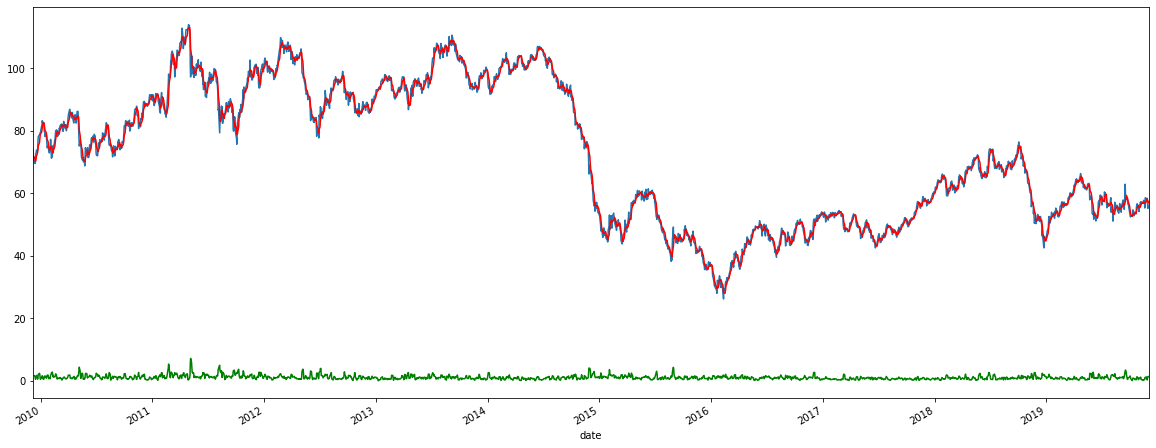

In [ ]:
plt.figure(figsize=(20,8))
rolling = df["Price"].rolling(window=5)
df["Price"].plot(grid = True)
rolling.mean().plot(color='red')
rolling.std().plot(color='green')

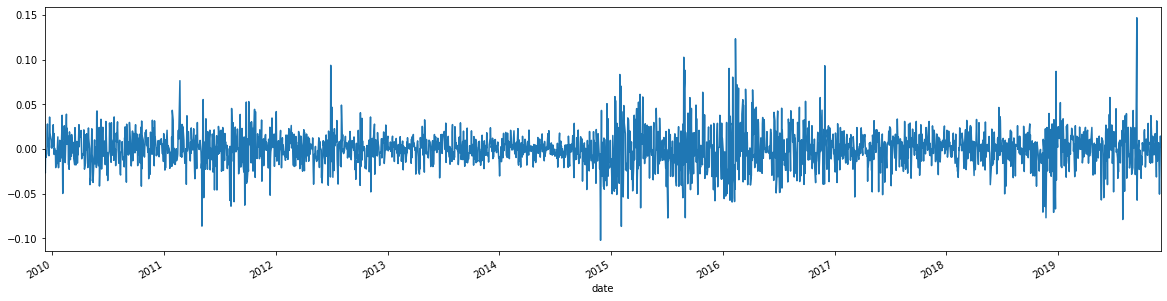

In [ ]:
plt.figure(figsize=(20,5))
rets = (df.Price/df.Price.shift(1))-1
rets.plot(label='return')

In [ ]:
df_complete = df.copy()
df=df["2017-12-07":"2019-12-07"].copy()

In [ ]:
def get_adftest(ts):
  # Dickey Fuller test
  print ('Results of Dickey-Fuller Test:')
  dftest = adfuller(ts, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)

def get_x_y(data,N,offset):
  x, y = [], []
  for i in range(offset, len(data)):
      x.append(data[i-N:i])
      y.append(data[i])
  x = np.array(x)
  y = np.array(y)
  
  return x, y

def get_rmse(ytrue,ypred):
  return np.sqrt(mean_squared_error(ytrue,ypred))

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    # acf1 = acf(fc-test)[1]  
    acf1=0                    # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

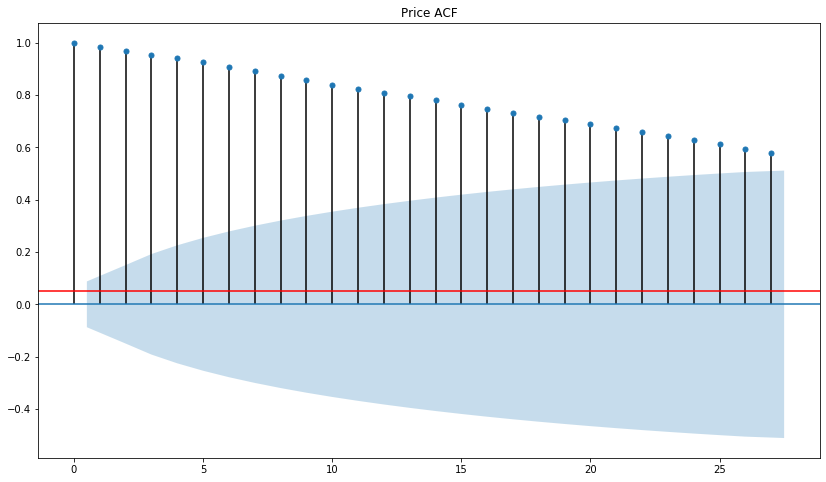

In [ ]:
plot_acf(df["Price"],title="Price ACF")
plt.axhline(y=0.05, color='r', linestyle='-')
plt.show()

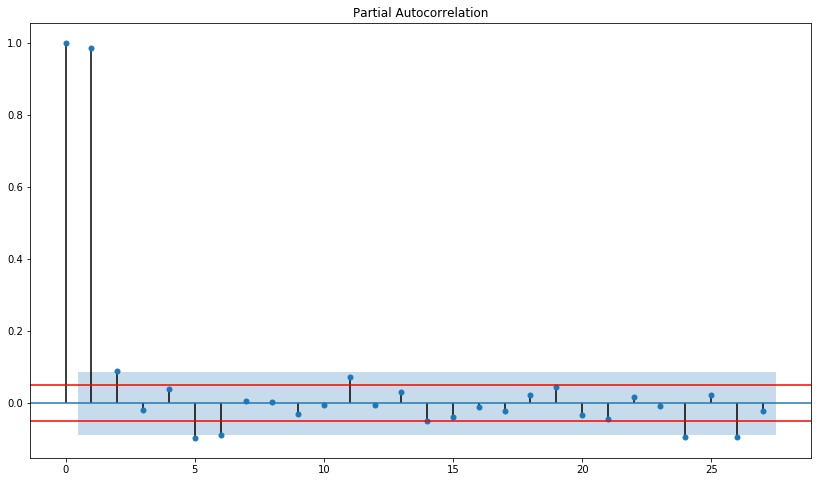

In [ ]:
plot_pacf(df["Price"])
plt.axhline(y=0.05, color='r', linestyle='-')
plt.axhline(y=-0.05, color='r', linestyle='-')
plt.show()

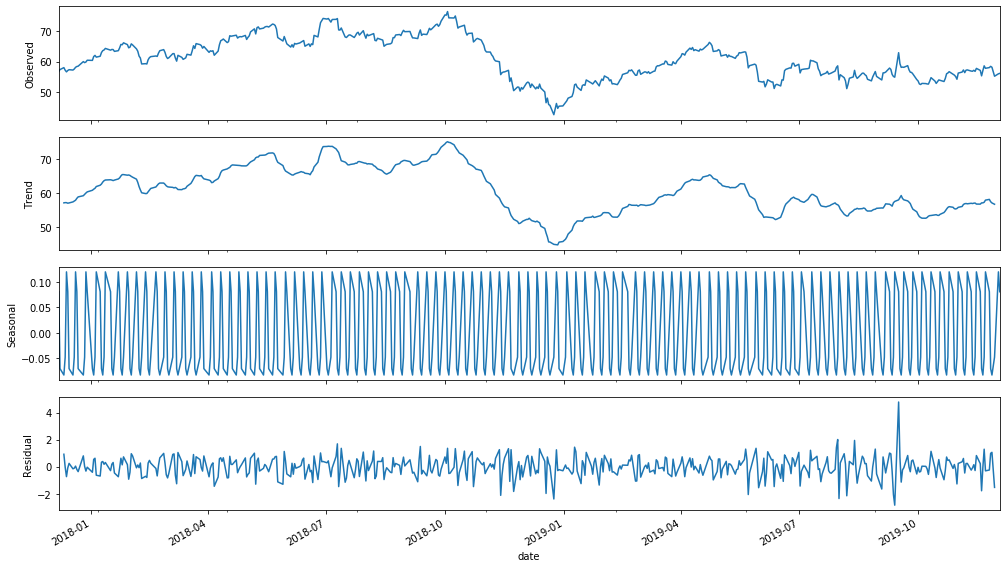

In [ ]:
decomposed_prices = sm.tsa.seasonal_decompose(df.Price, freq=5)
decomposed_prices.plot()
plt.show()

In [ ]:
get_adftest(df.Price)

Results of Dickey-Fuller Test:
Test Statistic                  -1.803988
p-value                          0.378484
#Lags Used                       1.000000
Number of Observations Used    499.000000
Critical Value (1%)             -3.443523
Critical Value (5%)             -2.867350
Critical Value (10%)            -2.569864
dtype: float64


Making the series stationary

In [ ]:
diff_price = (df['Price'] - df['Price'].shift(1)).to_frame().dropna()


In [ ]:
get_adftest(diff_price.Price)

Results of Dickey-Fuller Test:
Test Statistic                 -24.367144
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    499.000000
Critical Value (1%)             -3.443523
Critical Value (5%)             -2.867350
Critical Value (10%)            -2.569864
dtype: float64


In [ ]:
df.shape

(501, 1)

In [ ]:
st_index = 491
end_index = 501
pred_length = end_index-st_index

df_train = df.iloc[:st_index,:1]
df_test = df.iloc[st_index:,:1]

In [ ]:
model = ARIMA(df_train["Price"], order=(2,2,0))
result = model.fit()
# print(get_rmse())
print(result.summary())
# result.plot_predict(start=st_index, end=end_index)
# plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D2.Price   No. Observations:                  489
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -854.918
Method:                       css-mle   S.D. of innovations              1.389
Date:                Sun, 15 Dec 2019   AIC                           1717.836
Time:                        05:39:16   BIC                           1734.606
Sample:                             2   HQIC                          1724.423
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0009      0.031     -0.030      0.976      -0.061       0.059
ar.L1.D2.Price    -0.7310      0.043    -17.062      0.000      -0.815      -0.647
ar.L2.D2.Price    -0.3181      0.043

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


**Residuals**

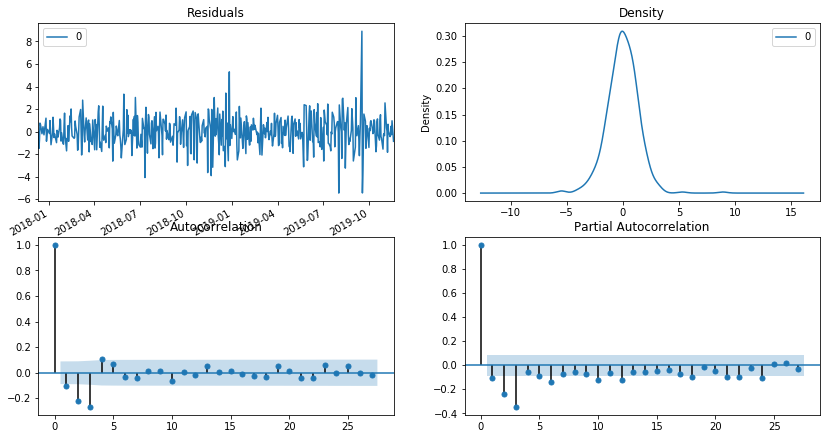

In [ ]:
# Plot residual errors

residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(2,2)
residuals.plot(title="Residuals", ax=ax[0][0])
residuals.plot(kind='kde', title='Density', ax=ax[0][1])
plot_acf(residuals.iloc[:,:], ax=ax[1][0])
plot_pacf(residuals.iloc[:,:], ax=ax[1][1])
plt.show()

**In-Sample forcast**

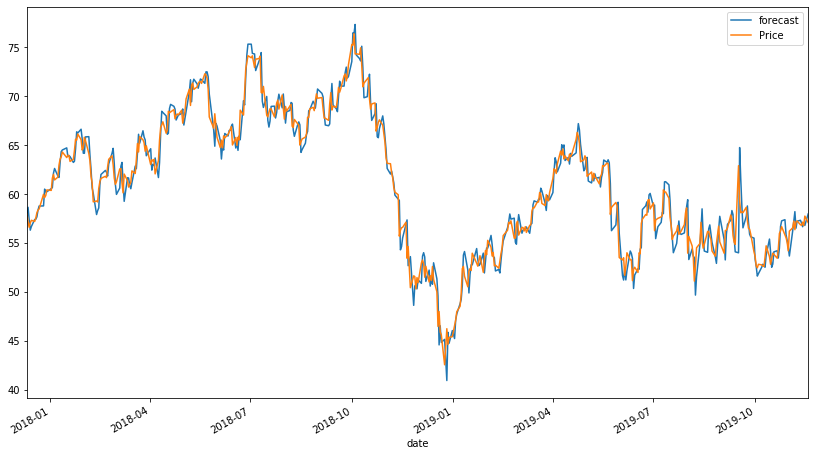

In [ ]:
# Actual vs Fitted
result.plot_predict(dynamic=False)
plt.show()

In [ ]:
# 

**Out of Smaple Forcast**

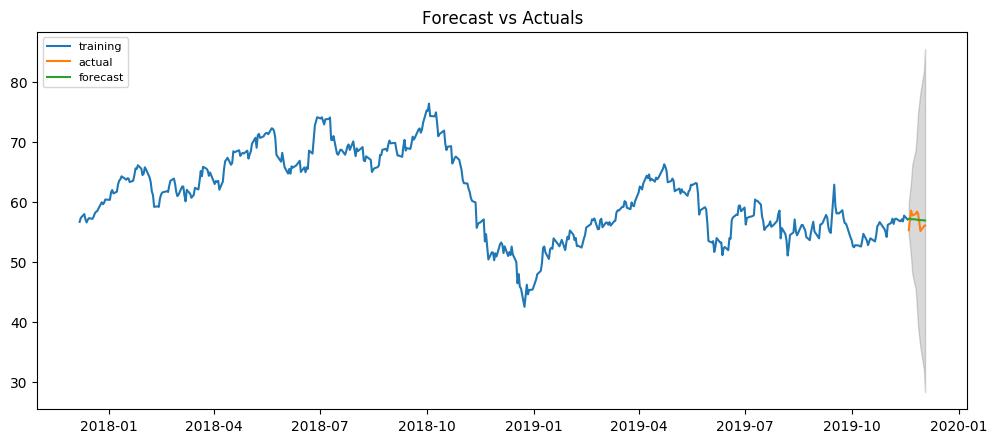

In [ ]:
# For out of sample 
fc, se, conf = result.forecast(pred_length, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
err=forecast_accuracy(fc, df_test.values.reshape(-1))
print('RMSE: ',err.get('rmse'))
print('MAE: ',err.get('mae'))
print('MAPE: ',err.get('mape'))

RMSE:  1.2254664838577205
MAE:  1.1207042567279217
MAPE:  0.019720749304651602


In [ ]:
# !pip install pmdarima

     |████████████████████████████████| 1.4MB 2.8MB/s 


In [ ]:
import pmdarima as pm

In [ ]:
model_auto = pm.auto_arima(df.Price, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_auto.summary())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=1602.945, BIC=1619.804, Fit time=0.386 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=1603.249, BIC=1611.679, Fit time=0.026 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=1601.332, BIC=1613.976, Fit time=0.077 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=1601.428, BIC=1614.072, Fit time=0.083 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=1601.250, BIC=1605.464, Fit time=0.029 seconds
Total fit time: 0.613 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  501
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -799.625
Date:                Sun, 15 Dec 2019   AIC                           1601.250
Time:                        05:40:03   BIC                           1605.464
Sample:                             0   

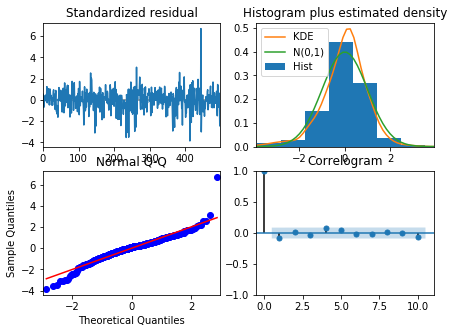

In [ ]:
model_auto.plot_diagnostics(figsize=(7,5))
plt.show()

In [ ]:
smodel = pm.auto_arima(df.Price, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=5,
                         start_P=0, seasonal=True,
                         d=None, D=None, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 5); AIC=1602.055, BIC=1623.128, Fit time=0.615 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 5); AIC=1603.249, BIC=1611.679, Fit time=0.024 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 5); AIC=1601.408, BIC=1618.267, Fit time=0.169 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 5); AIC=1601.268, BIC=1618.127, Fit time=0.165 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 5); AIC=1601.250, BIC=1605.464, Fit time=0.020 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 5); AIC=1603.731, BIC=1616.374, Fit time=0.104 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 5); AIC=1603.525, BIC=1616.169, Fit time=0.127 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 5); AIC=1604.254, BIC=1621.112, Fit time=0.358 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 5); AIC=1601.332, BIC=1613.976, Fit time=0.079 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_o

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  501
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -799.625
Date:                Sun, 15 Dec 2019   AIC                           1601.250
Time:                        05:40:06   BIC                           1605.464
Sample:                             0   HQIC                          1602.904
                                - 501                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.4342      0.049     29.483      0.000       1.339       1.530
===================================================================================
Ljung-Box (Q):                       39.12   Jarque-Bera (JB):               511.28
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

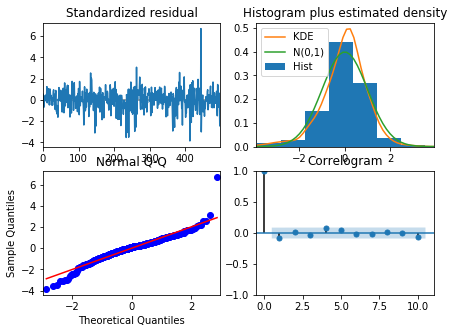

In [ ]:
smodel.plot_diagnostics(figsize=(7,5))
plt.show()

**SARIMA Model**

In [ ]:
ar_order = (0,1,0)
sar_order = (0,0,0,5)
smodel = SARIMAX(df_train.Price, order=ar_order, seasonal_order=sar_order)
sresult=smodel.fit()
print(sresult.summary())

                           Statespace Model Results                           
Dep. Variable:                  Price   No. Observations:                  491
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -782.046
Date:                Sun, 15 Dec 2019   AIC                           1566.092
Time:                        05:41:31   BIC                           1570.286
Sample:                             0   HQIC                          1567.739
                                - 491                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.4250      0.048     29.535      0.000       1.330       1.520
Ljung-Box (Q):                       40.88   Jarque-Bera (JB):               535.41
Prob(Q):                              0.43   Pr

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


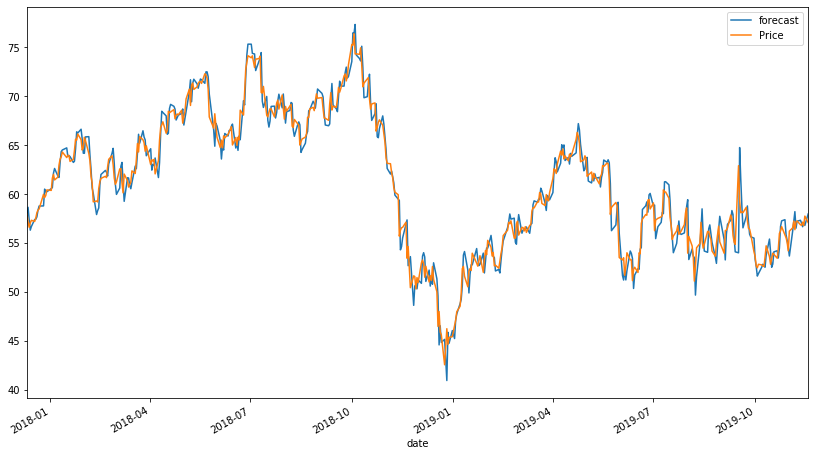

In [ ]:
result.plot_predict(dynamic=False)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


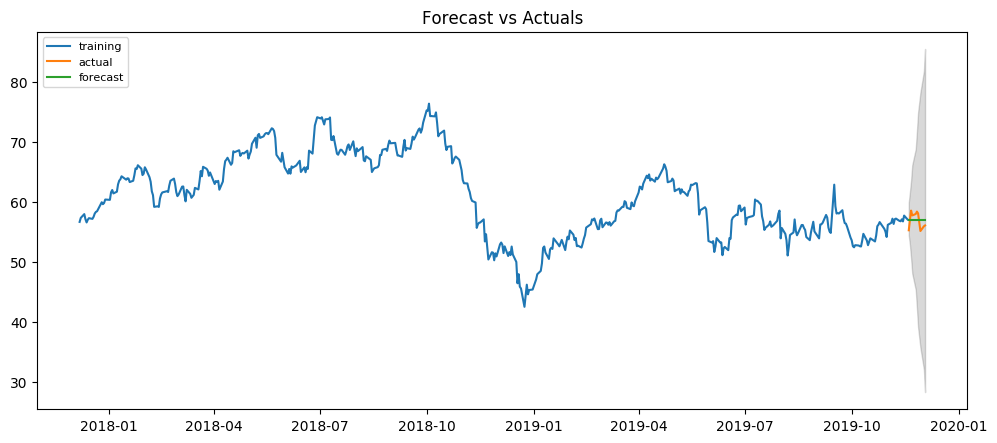

In [ ]:
# For out of sample 
fc = sresult.forecast(pred_length)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc.values, index=df_test.index)
# lower_series = pd.Series(conf[:, 0], index=df_test.index)
# upper_series = pd.Series(conf[:, 1], index=df_test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [ ]:
err=forecast_accuracy(fc, df_test.values.reshape(-1))
print('RMSE: ',err.get('rmse'))
print('MAE: ',err.get('mae'))
print('MAPE: ',err.get('mape'))

RMSE:  1.244216540639128
MAE:  1.1325999999999994
MAPE:  0.019937784305170896


**Using neural Network**

In [ ]:
from keras.models import Sequential,Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow import set_random_seed
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [ ]:
df=df_complete.copy()
df=df['2014-12-07':'2019-12-07'].copy()

In [ ]:
train = df.iloc[:1207,:]
test = df.iloc[1207:,:]
print(train.shape, test.shape)

(1207, 1) (50, 1)


In [ ]:
ss= StandardScaler()
train_scaled = ss.fit_transform(np.array(train.Price).reshape(-1,1))
test_scaled = ss.fit_transform(np.array(test.Price).reshape(-1,1))

In [ ]:
x_train_scaled, y_train_scaled = get_x_y(train_scaled, 1, 1)
print(x_train_scaled.shape, y_train_scaled.shape)

(1206, 1, 1) (1206, 1)


In [ ]:
dropout_prob = 0.5
lstm_units = 100
optimizer='adam'
epochs = 20
batch_size = 1
model_seed = 100

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units, return_sequences=True))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=1)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/40





1206/1206 [==============================] - 19s 16ms/step - loss: 0.1872
Epoch 2/40
1206/1206 [==============================] - 14s 11ms/step - loss: 0.0897
Epoch 3/40
1206/1206 [==============================] - 14s 11ms/step - loss: 0.0838
Epoch 4/40
1206/1206 [==============================] - 14s 11ms/step - loss: 0.0672
Epoch 5/40
1206/1206 [==============================] - 14s 11ms/step - loss: 0.0679
Epoch 6/40
1206/1206 [==============================] - 14s 12ms/step - loss: 0.0672
Epoch 7/40
1206/1206 [==============================] - 14s 12ms/step - loss: 0.0599
Epoch 8/40
1206/1206 [==============================] - 15s 12ms/step - loss: 0.0650
Epoch 9/40
1206/1206 [==============================] - 15s 12ms/step - loss: 0.0668
Epoch 10/40
1

In [ ]:
X_test_scaled, y_test_scaled = get_x_y(test_scaled,1,1)
print(test_scaled.shape)
print(X_test_scaled.shape, y_test_scaled.shape)

(50, 1)
(49, 1, 1) (49, 1)


In [ ]:
pred = model.predict(X_test_scaled)
train_pred = model.predict(x_train_scaled)

In [ ]:
t_pred= ss.inverse_transform(pred)
y_test = ss.inverse_transform(y_test_scaled)
train_pred = ss.inverse_transform(train_pred)
x_train = ss.inverse_transform(x_train_scaled)

In [ ]:
err=forecast_accuracy(t_pred, y_test)
print('RMSE: ',err.get('rmse'))
print('MAE: ',err.get('mae'))
print('MAPE: ',err.get('mape'))

RMSE:  0.9244961332590909
MAE:  0.7056951941665331
MAPE:  0.012724292555443297


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [ ]:
hist = pd.DataFrame({'pred':train_pred.reshape(-1),'train':x_train.reshape(-1)},index=train.index[:-1])
est = pd.DataFrame({'pred':t_pred.reshape(-1),'ytest':y_test.reshape(-1)}, index=test.index[:-1])

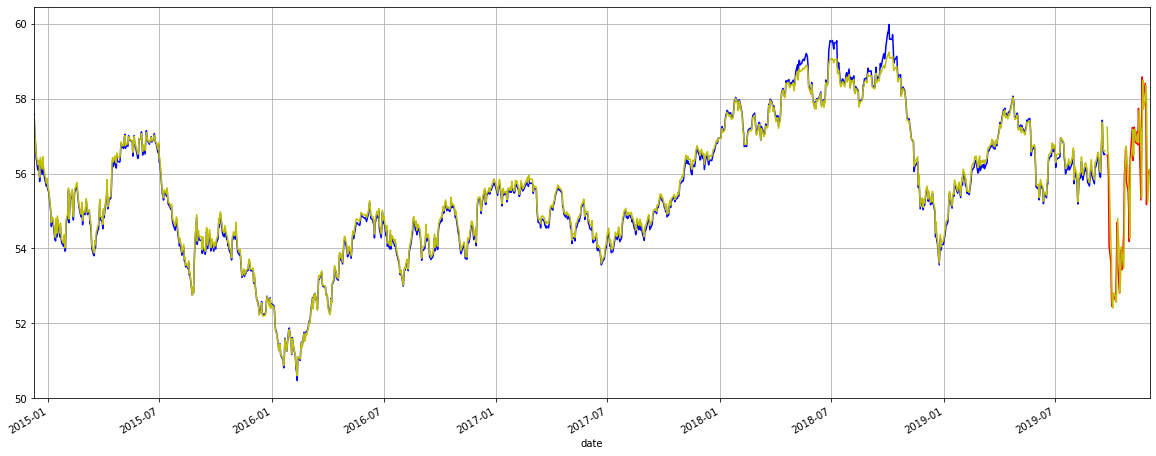

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8
ax= hist.train.plot(style='b-', grid=True, label="Actual")
ax = est.ytest.plot(style='r-', grid=True, ax=ax)
ax= est.pred.plot(style='y-',grid=True, ax=ax, label="Prediction")
ax= hist.pred.plot(style='y-',grid=True, ax=ax, )


In [ ]:
est.head()

,pred,ytest
date,,
2019-09-24,57.236210,56.49
2019-09-25,56.587917,56.41
2019-09-26,56.521530,55.91
2019-09-27,56.047741,54.07
2019-09-30,54.159092,53.62


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# pip install selenium

     |████████████████████████████████| 911kB 36.8MB/s 


In [ ]:
# !apt-get update # to update ubuntu to correctly run apt install
# !apt install chromium-chromedriver
# !cp /usr/lib/chromium-browser/chromedriver /usr/bin
# import sys
# sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [80.2 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [1

In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
# from selenium import webdriver

In [ ]:
url = "https://in.investing.com/commodities/crude-oil-historical-data"
r = requests.get(url) 
# print(r.content) 

In [ ]:
# chrome_options = webdriver.ChromeOptions()
# chrome_options.add_argument('--headless')
# chrome_options.add_argument('--no-sandbox')
# chrome_options.add_argument('--disable-dev-shm-usage')
# wd = webdriver.Chrome('chromedriver',options=chrome_options)
# wd.get(url)

In [ ]:
url = "https://www.investing.com/instruments/HistoricalDataAjax"

payload = {'header': 'BTC/USD Kraken Historical Data', 'st_date': '12/01/2018', 'end_date': '12/01/2018', 'sort_col': 'date', 'action': 'historical_data', 'smlID': '145284', 'sort_ord': 'DESC', 'interval_sec': 'Daily', 'curr_id': '49799'}

requests.post(url, data=payload, headers=urlheader)

b'\n<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN"\n "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">\n<html>\n  <head>\n    <title>403 You are banned from this site.  Please contact via a different client configuration if you believe that this is a mistake.</title>\n  </head>\n  <body>\n    <h1>Error 403 You are banned from this site.  Please contact via a different client configuration if you believe that this is a mistake.</h1>\n    <p>You are banned from this site.  Please contact via a different client configuration if you believe that this is a mistake.</p>\n    <h3>Guru Meditation:</h3>\n    <p>XID: 1515010616</p>\n    <hr>\n    <p>Varnish cache server</p>\n  </body>\n</html>\n'